# Forecast using Nelson Siegel Factors

Instead of using PCA to extract effective dimensions the space of yield curves, we can also use parameterized models like the Nelson-Siegel model to extract factors that has economical meaning. Then we use these factors for VAR modeling and forecasting.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [2]:
# Import data
df = pd.read_csv('../data/yield.csv')
df = df.set_index('DATE')
df.index = pd.to_datetime(df.index)
name = list(df.columns.values)
df

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2005-01-03,1.99,2.32,2.63,2.79,3.10,3.28,3.64,3.94,4.23,4.84,4.85
2005-01-04,2.05,2.33,2.63,2.82,3.20,3.38,3.72,4.02,4.29,4.91,4.91
2005-01-05,2.04,2.33,2.63,2.83,3.22,3.39,3.73,4.02,4.29,4.88,4.88
2005-01-06,2.04,2.31,2.63,2.82,3.18,3.36,3.71,4.01,4.29,4.88,4.89
2005-01-07,2.03,2.32,2.63,2.82,3.20,3.40,3.73,4.03,4.29,4.88,4.88
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03,4.35,4.18,3.96,3.77,3.61,3.58,3.69,3.92,4.22,4.85,4.90
2025-09-04,4.33,4.16,3.94,3.76,3.59,3.55,3.65,3.87,4.17,4.81,4.86
2025-09-05,4.29,4.07,3.85,3.65,3.51,3.48,3.59,3.80,4.10,4.72,4.78


In [3]:
# Split into training and test data
train_stop = -756   # by slicing index (12 months business calendar ahead)
df_train = df.iloc[:train_stop]
df_test = df.iloc[train_stop:]

### Nelson Siegel function

\begin{align}
y(\tau) &= \beta_0 + \beta_1 \left(\frac{1 - e^{-\lambda\tau}}{\lambda\tau}\right) + \beta_2 \left(\frac{1 - e^{-\lambda\tau}}{\lambda\tau} - e^{-\lambda\tau}\right) \\
&= \beta_0 L_0 + \beta_1 L_1 + \beta_2 L_2
\end{align}

In [4]:
# Fit yield curve using NS function for each date
import statsmodels.api as sm

maturities = np.array([1/12, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
lamb = 0.3

def loadings(lam, tau):
    ''' Return (len(tau) x 3) matrix '''
    L0 = np.ones(len(tau))
    L1 = ((1 - np.exp(-lam*tau)) / (lam*tau))
    L2 = ((1 - np.exp(-lam*tau)) / (lam*tau) - np.exp(-lam*tau))
    return np.vstack([L0, L1, L2]).T


# Use OLS to estimate betas for each date
def OLS_est(y):
    ''' Return OLS estimates for given yield data y at specific date '''
    model = sm.OLS(y, loadings(lamb, maturities)).fit()
    return model.params
    

# Extracted factors
NS_factors = []
for i in range(len(df)):
    y = df.iloc[i].to_numpy()
    NS_factors.append(OLS_est(y))
NS_factors = np.array(NS_factors)
NS_factors

array([[ 5.18231281, -2.95895268,  0.21051191],
       [ 5.21435502, -2.96999666,  0.41379025],
       [ 5.15841262, -2.91838209,  0.5508189 ],
       ...,
       [ 5.56448046, -1.44709399, -4.21253722],
       [ 5.4538778 , -1.34280552, -4.09787027],
       [ 5.46890033, -1.35516032, -3.99532227]], shape=(5176, 3))

In [5]:
# Use VAR modeling on NS_factors
NS_factors_train = NS_factors[:-len(df_test)]

NS_factors_train_diff = []
for i in range(1,len(NS_factors_train)):
    NS_factors_train_diff.append(NS_factors_train[i] - NS_factors_train[i-1])
NS_factors_train_diff = np.array(NS_factors_train_diff)


# Use VAR (Vector Autoregression) to model the dynamics of the difference of scores
var_model_1 = VAR(NS_factors_train)
var_model_2 = VAR(NS_factors_train_diff)

maxlag = 20
var_res_1 = var_model_1.fit(maxlags=maxlag, ic='aic')
var_res_2 = var_model_2.fit(maxlags=maxlag, ic='aic')      # Set max la = 15


# Forecast score using the fitted VAR model

horizons = [21, 63, 126, 252]  # 1/3/6/12 months ahead
horizon_month = [1,3,6,12]

def produce_forecasts(model, horizon):
    fore = []
    for i in range(len(df_test)):
        fore.append(model.forecast(NS_factors[-len(df_test)-model.k_ar-horizon+1+i : -len(df_test)-horizon+1+i], steps=1)[-1])
    return np.array(fore)

# Version 1 (raw score)
score_fore_1 = []
for h in horizons:
    score_fore_1.append(produce_forecasts(var_res_1, h))

In [6]:
# Use forecasted factors to interpolate yield forecastings for each date

def NS_yields(factors, lam, tau):
    return factors @ loadings(lam, tau).T


yield_fore_1 = []    # forecasts of 1/3/6/12 months ahead
for i in range(len(horizons)):
    res = pd.DataFrame(NS_yields(score_fore_1[i], lamb, maturities), columns=df.columns, index=df_test.index)
    res.to_csv(f'../results/VAR-NS_fore_{horizon_month[i]}.csv', index=False)
    yield_fore_1.append(res)
 
yield_fore_1[0]  # forecasts of one month ahead

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2022-08-30,2.675533,2.680289,2.687316,2.700967,2.726574,2.749866,2.789740,2.821634,2.857583,2.918803,2.943147
2022-08-31,2.698591,2.717206,2.743274,2.789338,2.861180,2.912176,2.972875,3.001030,3.014695,3.004109,2.992612
2022-09-01,2.659731,2.681902,2.712774,2.766732,2.848813,2.904618,2.965198,2.986859,2.987530,2.944192,2.917383
2022-09-02,2.676320,2.690846,2.711283,2.747720,2.805683,2.848170,2.901931,2.930386,2.949571,2.958096,2.956288
2022-09-06,2.748731,2.776027,2.813942,2.879903,2.979151,3.045300,3.113820,3.134341,3.127093,3.057834,3.018041
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03,4.309884,4.244893,4.157099,4.012778,3.825538,3.737484,3.739230,3.857520,4.094425,4.691927,4.971298
2025-09-04,4.335425,4.270073,4.181686,4.036029,3.845694,3.754243,3.749099,3.861053,4.090085,4.672810,4.946009
2025-09-05,4.305608,4.240177,4.151807,4.006614,3.818512,3.730438,3.733567,3.854049,4.094387,4.699539,4.982339


In [7]:
# RMSE table

def RMSE_table(yield_fores):
    RMSE = []
    for yield_fore in yield_fores:
        RMSE.append(np.sqrt(np.mean((yield_fore.to_numpy() - df_test.to_numpy())**2, axis=0)))
    RMSE = np.array(RMSE)
    ind = ['1', '3', '6', '12']
    return pd.DataFrame(RMSE, columns=df.columns, index=ind)

# Save results
RMSE_table(yield_fore_1).to_csv('../results/VAR-NS_RMSE.csv', index=False)
RMSE_table(yield_fore_1)

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
1,0.250358,0.210706,0.329299,0.378523,0.351474,0.344619,0.331931,0.330129,0.312470,0.331692,0.292958
3,0.431518,0.562164,0.686313,0.701089,0.621081,0.588350,0.546826,0.532832,0.495214,0.507631,0.420116
6,1.086766,1.223814,1.295627,1.206546,0.940014,0.786995,0.625222,0.586658,0.537736,0.641700,0.535362
12,2.295554,2.405383,2.423557,2.245642,1.824755,1.563945,1.249898,1.124578,0.998677,1.098111,0.950456


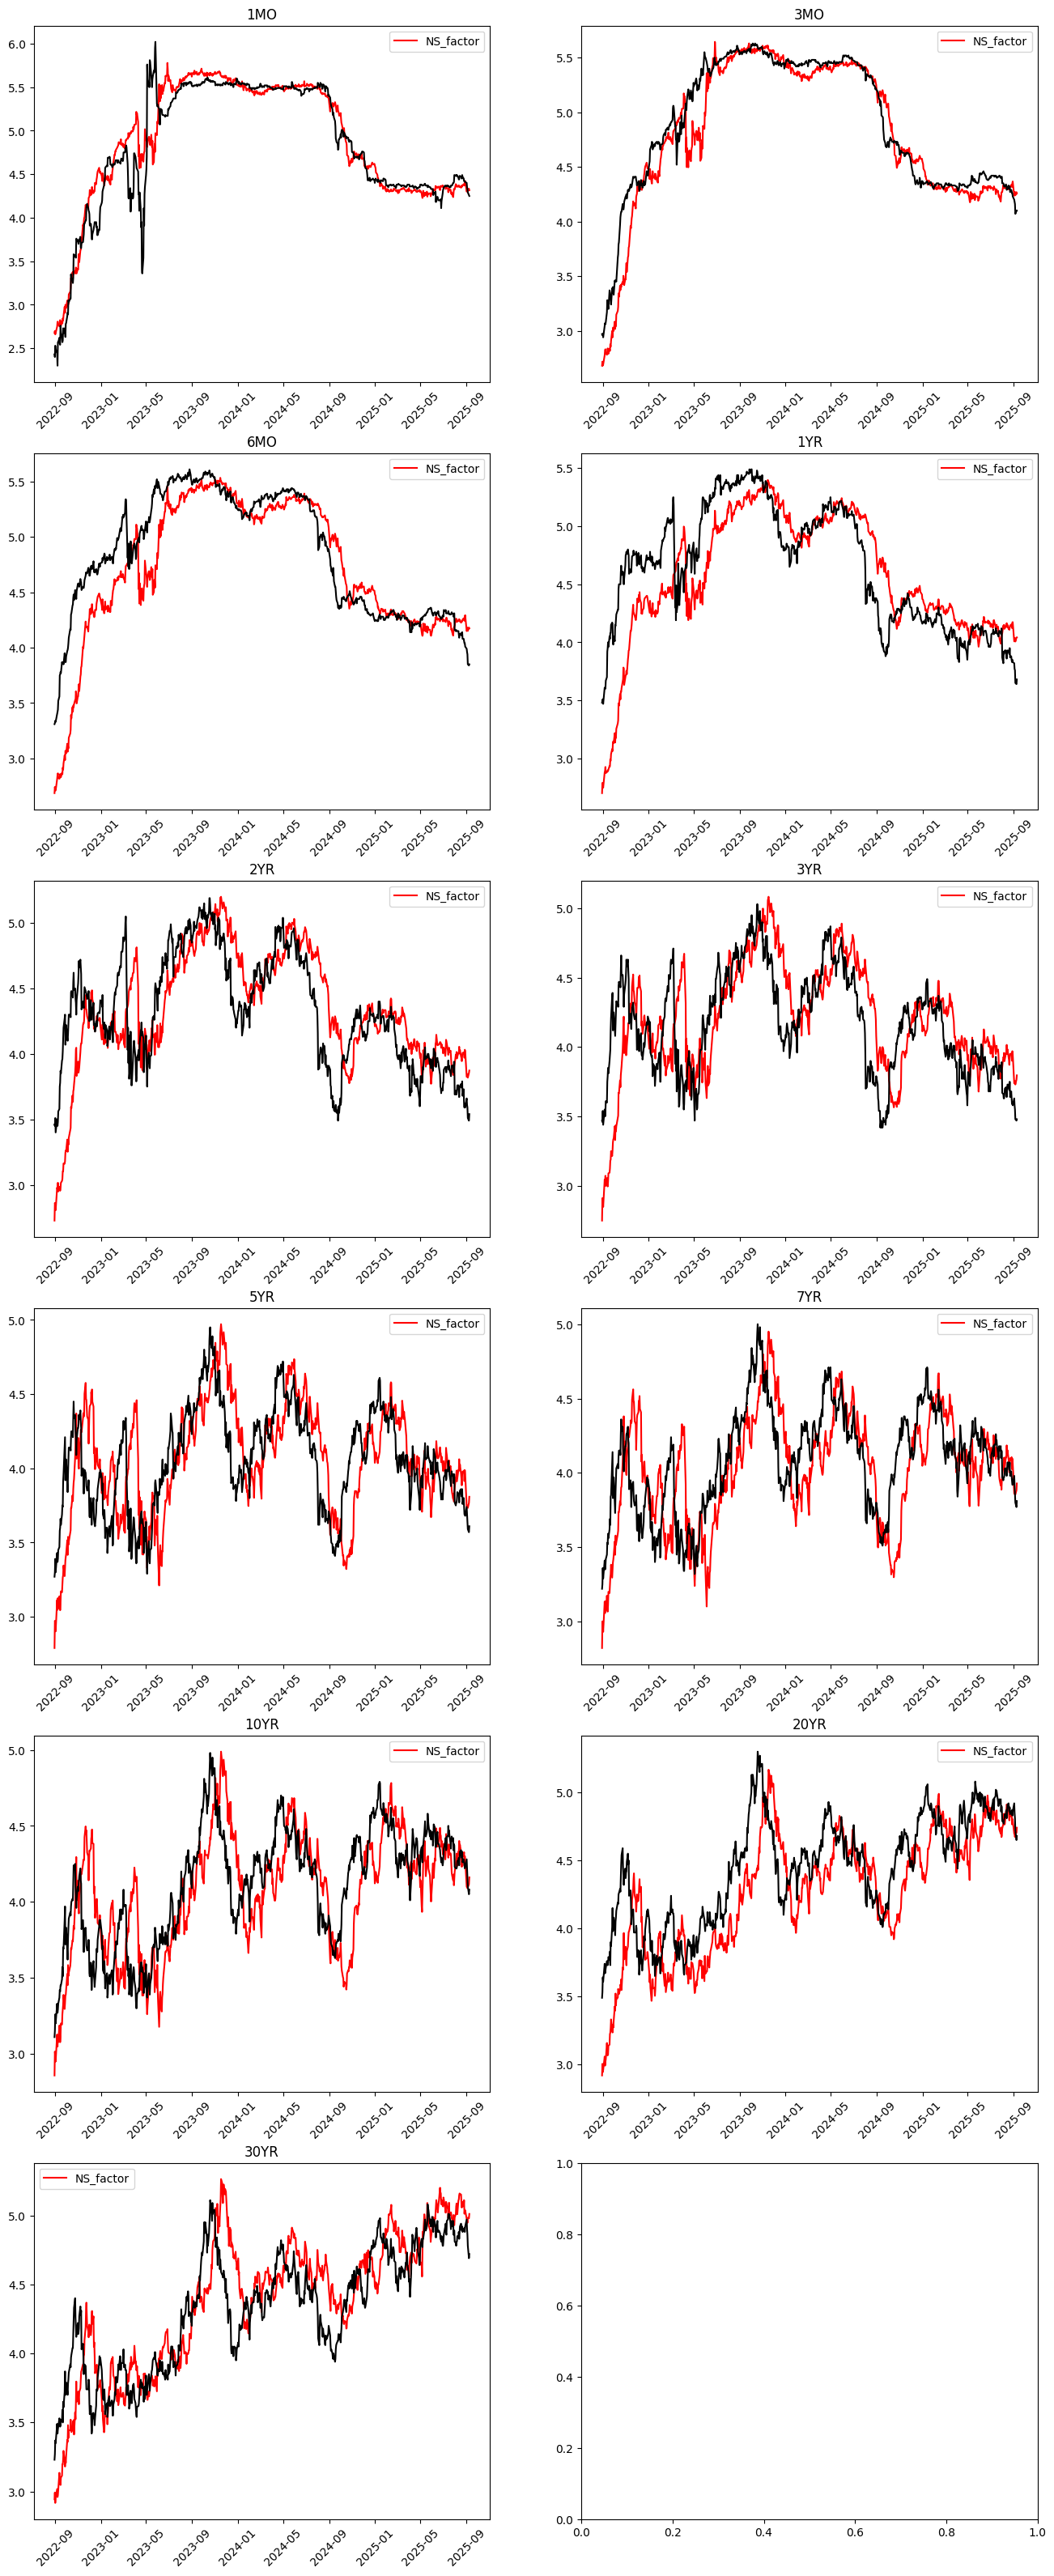

In [8]:
# Plot the forecasted (1 month ahead) vs actual yield 
fig, ax = plt.subplots(6,2,figsize=(16,40))

for i in range(6):
    for j in range(2):
        ind = 2*i+j
        if ind == len(name): break
        ax[i, j].plot(yield_fore_1[0][name[ind]], color='red', label='NS_factor')
        #ax[i, j].plot(yield_fore_2[name[ind]], color='blue', label='score_diff')
        ax[i, j].plot(df_test[name[ind]], color='black')
        ax[i, j].legend()
        ax[i, j].tick_params('x', labelrotation=45)
        ax[i, j].set_title(name[ind])